In [1]:
# ! pip install tensorflow==2.0.0 tensorflow-hub==0.10.0 bert-for-tf2==0.14.7 sentencepiece==0.1.94 matplotlib==3.3.4 seaborn==0.11.2 pydot==1.4.2 graphviz==0.19.1 pandas==1.1.5 scikit-learn==0.24.2 nltk==3.4.5 gensim==3.8.1

In [2]:
# import nltk
# nltk.download('punkt')

In [3]:
import os
Use_COLAB = False

if Use_COLAB:
    from google.colab import drive 
    #drive is a module that allows us use Python to interact with google drive

    drive.mount('/content/drive') 
    #mounting google drive allows us to work with its contents

if Use_COLAB:
    COLAB_DIR = '/content/drive/MyDrive/Colab Notebooks'
    project_dir = os.path.join(COLAB_DIR, 'ACP')
else: 
    project_dir = '.'

In [4]:
cd $project_dir

In [5]:
from dataset import SemEval_Dataset
from preprocess import Preprocessor

In [6]:
from sklearn.metrics import classification_report
from GraphPlot import plot_acc_loss, plot_seaborn_confusion_matrix

In [7]:
import tensorflow as tf
import numpy as np

In [8]:
import argparse

''' dataset files'''
dataset_files = {
    'Restaurants': {
        'train': os.path.join(project_dir, 'data', 'SemEval2014', 'Restaurants_Train_v2.xml'),
        'test': os.path.join(project_dir, 'data', 'SemEval2014', 'Restaurants_Test_Gold.xml')
    },
    'Laptops': {
        'train': os.path.join(project_dir, 'data', 'SemEval2014', 'Laptop_Train_v2.xml'),
        'test': os.path.join(project_dir, 'data', 'SemEval2014', 'Laptops_Test_Gold.xml')
    }
}

# Hyper Parameters
parser = argparse.ArgumentParser()
parser.add_argument('--model_type', default='glove', type=str, help=['bert', 'elmo', 'word2vec', 'glove'])
parser.add_argument('--dataset_domain', default='Restaurants', type=str, help=', '.join(dataset_files.keys()))

parser.add_argument('--num_epochs', default=20, type=int, help='try larger number for non-BERT models')
parser.add_argument('--batch_size', default=64, type=int, help='try 16, 32, 64 for BERT models')
parser.add_argument('--patience', default=5, type=int, help='in case of EarlyStopping')
parser.add_argument('--validation_split', default=0.2, type=float, help='set ratio between 0 and 1 for validation split')


parser.add_argument('--max_seq_len', default=100, type=int)
parser.add_argument('--lstm_unit', default=128, type=int)
parser.add_argument('--removeConflict', default=0, type=int)


''' parse arguments '''
opt = parser.parse_args(args=[])

if opt.removeConflict:
    opt.polarity_index = {'positive': 0, 'negative': 1, 'neutral': 2} 
else:    
    opt.polarity_index = {'positive': 0, 'negative': 1, 'neutral': 2, 'conflict': 3} 
opt.reversed_polarity_index = dict(map(reversed, opt.polarity_index.items()))


opt.category_dict = {'service':0, 'food':1, 'anecdotes/miscellaneous':2, 'ambience':3, 'price':4}
opt.category_list = ['service', 'food', 'anecdotes/miscellaneous', 'ambience', 'price']



opt.dataset_files = dataset_files[opt.dataset_domain]

opt.prediction_unit = len(opt.polarity_index)

opt.model_type = opt.model_type.lower()
assert opt.model_type in ['bert', 'elmo', 'word2vec', 'glove']


emb_dims = {
    'bert': 768,
    'elmo': 1024,
    'glove': 300,
    'word2vec': 300
}
opt.emb_dim = emb_dims[opt.model_type]

opt.project_dir = project_dir
opt

Namespace(batch_size=64, category_dict={'service': 0, 'food': 1, 'anecdotes/miscellaneous': 2, 'ambience': 3, 'price': 4}, category_list=['service', 'food', 'anecdotes/miscellaneous', 'ambience', 'price'], dataset_domain='Restaurants', dataset_files={'train': './data/SemEval2014/Restaurants_Train_v2.xml', 'test': './data/SemEval2014/Restaurants_Test_Gold.xml'}, emb_dim=300, lstm_unit=128, max_seq_len=100, model_type='glove', num_epochs=20, patience=5, polarity_index={'positive': 0, 'negative': 1, 'neutral': 2, 'conflict': 3}, prediction_unit=4, project_dir='.', removeConflict=0, reversed_polarity_index={0: 'positive', 1: 'negative', 2: 'neutral', 3: 'conflict'}, validation_split=0.2)

### Data Loading

In [9]:
semeval = SemEval_Dataset(opt, for_aspect_category = True)

In [10]:
semeval.training_data_frame.head()

,id,review,aspect_category,aspect_category_polarity
0,3121,but the staff was so horrible to us.,service,negative
1,2777,"to be completely fair, the only redeeming fact...",food,positive
2,2777,"to be completely fair, the only redeeming fact...",anecdotes/miscellaneous,negative
3,1634,"the food is uniformly exceptional, with a very...",food,positive
4,2534,where gabriela personaly greets you and recomm...,service,positive


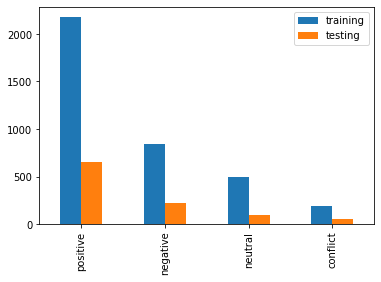

In [11]:
import pandas as pd

df = pd.DataFrame({'training': semeval.training_data_frame['aspect_category_polarity'].value_counts(),
                   'testing': semeval.testing_data_frame['aspect_category_polarity'].value_counts()})
ax = df.plot.bar()

In [12]:
pp = Preprocessor(opt.model_type, opt.polarity_index)
x_train, x_train_cat, y_train, x_test, x_test_cat, y_test = pp.preprocess_data(semeval.training_data_frame, semeval.testing_data_frame, opt.category_dict, opt.max_seq_len, opt.project_dir)

In [13]:
print('Shape of training data tensor:', x_train.shape)
print('Shape of training category data tensor:', x_train_cat.shape)
print('Shape of training label tensor:', y_train.shape)
print()
print('Shape of testing data tensor:', x_test.shape)
print('Shape of testing category data tensor:', x_test_cat.shape)
print('Shape of testing label tensor:', y_test.shape)

Shape of training data tensor: (3713, 100, 300)
Shape of training category data tensor: (3713,)
Shape of training label tensor: (3713,)

Shape of testing data tensor: (1025, 100, 300)
Shape of testing category data tensor: (1025,)
Shape of testing label tensor: (1025,)


### Model Training

In [14]:
from models import ACP_Model
model = ACP_Model(opt)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
wordInputLayer (InputLayer)     [(None, 100, 300)]   0                                            
__________________________________________________________________________________________________
categoryInputLayer (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 300)     541200      wordInputLayer[0][0]             
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 300)       1500        categoryInputLayer[0][0]         
______________________________________________________________________________________________

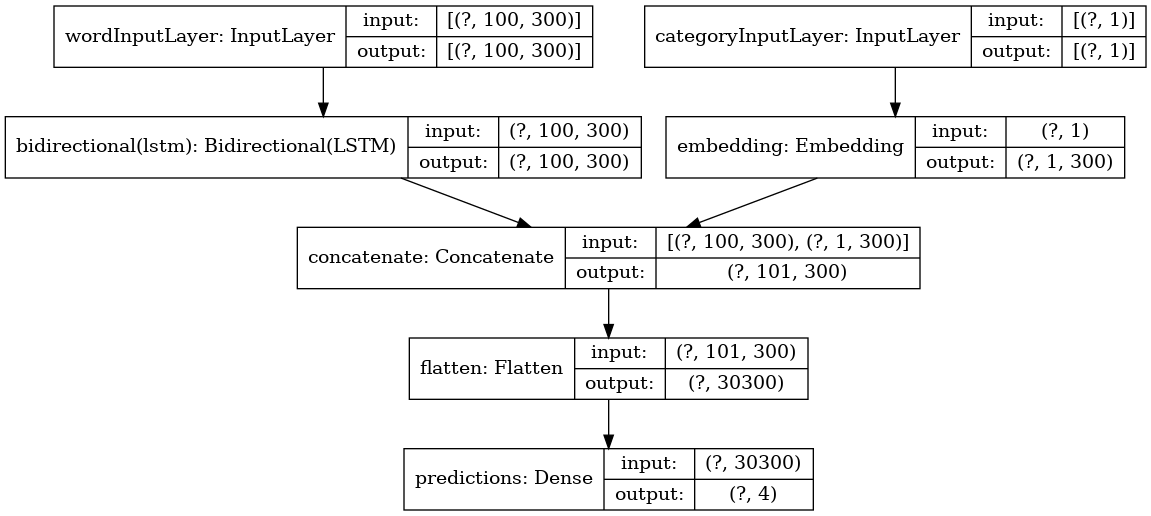

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True
    #                           , to_file='ATE_APD_full.png'
                              )

In [16]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,  min_delta=0, patience=opt.patience)
# mc = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_sparse_categorical_accuracy', mode='max', verbose=1, save_best_only=True) 

In [17]:
print('# Fit model on training data')
history = model.fit([x_train, x_train_cat], y_train
          , validation_split=opt.validation_split
          , batch_size=opt.batch_size
          , epochs=opt.num_epochs
          , callbacks=[es]
#           , callbacks = [lr_schedule]
          , verbose = 2
                      )

# Fit model on training data
Train on 2970 samples, validate on 743 samples
Epoch 1/20
2970/2970 - 25s - loss: 1.0160 - sparse_categorical_accuracy: 0.5852 - val_loss: 1.0413 - val_sparse_categorical_accuracy: 0.5855
Epoch 2/20
2970/2970 - 21s - loss: 0.8716 - sparse_categorical_accuracy: 0.6424 - val_loss: 0.9082 - val_sparse_categorical_accuracy: 0.6447
Epoch 3/20
2970/2970 - 21s - loss: 0.7978 - sparse_categorical_accuracy: 0.6758 - val_loss: 1.2039 - val_sparse_categorical_accuracy: 0.5262
Epoch 4/20
2970/2970 - 22s - loss: 0.7576 - sparse_categorical_accuracy: 0.6852 - val_loss: 0.8551 - val_sparse_categorical_accuracy: 0.6649
Epoch 5/20
2970/2970 - 22s - loss: 0.7118 - sparse_categorical_accuracy: 0.7155 - val_loss: 1.0712 - val_sparse_categorical_accuracy: 0.6030
Epoch 6/20
2970/2970 - 22s - loss: 0.6623 - sparse_categorical_accuracy: 0.7374 - val_loss: 0.8719 - val_sparse_categorical_accuracy: 0.6581
Epoch 7/20
2970/2970 - 25s - loss: 0.6327 - sparse_categorical_accuracy: 0.749

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


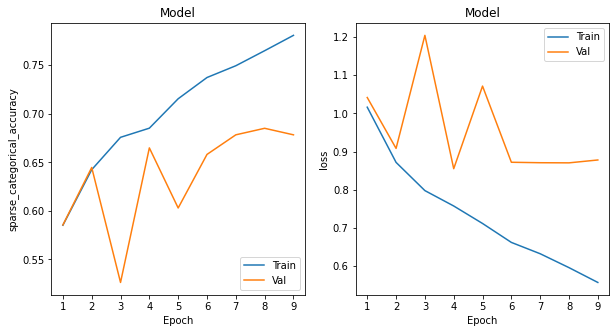

In [18]:
plot_acc_loss(history, 'sparse_categorical_accuracy', 'loss', savePDF= False)

### Model Evaluation

In [19]:
# Evaluate the model on the test data using `evaluate`

print('\n# Evaluate on training data')
results = model.evaluate([x_train, x_train_cat], y_train, batch_size=128, verbose=0)
print('training loss, training acc:', results)


print('\n# Evaluate on test data')
results = model.evaluate([x_test, x_test_cat], y_test, batch_size=128, verbose=0)
print('test loss, test acc:', results)


# Evaluate on training data
training loss, training acc: [0.5070151419386593, 0.81281984]

# Evaluate on test data
test loss, test acc: [0.7019328081043347, 0.74439025]


In [20]:
y_pred_prob = model.predict([x_test, x_test_cat])
y_pred = y_pred_prob.argmax(axis=1)

In [21]:
print(classification_report(y_test, y_pred))
print(results[1])

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       657
           1       0.64      0.63      0.63       222
           2       0.51      0.38      0.44        94
           3       0.25      0.02      0.04        52

    accuracy                           0.74      1025
   macro avg       0.55      0.48      0.49      1025
weighted avg       0.71      0.74      0.72      1025

0.74439025


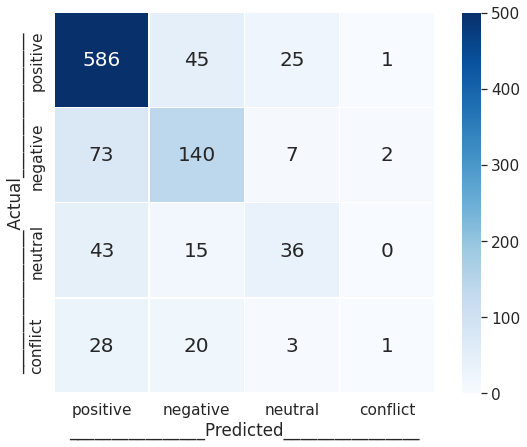

In [22]:
# imageName = f'confusionMatrix_BERT_{results[1]}.pdf'
imageName = None
plot_seaborn_confusion_matrix(y_test, y_pred, opt.polarity_index, normalize=None, imageName = imageName)

In [23]:
def export_results(data_frame, reversed_Polarity_index, y_pred, output_file):
    data_frame['predicted_polarity'] = pd.DataFrame({'predicted_polarity':y_pred}).replace(reversed_Polarity_index)
    data_frame.to_csv(output_file, index=False)

os.makedirs(os.path.join(project_dir, 'Results'), exist_ok=True)
output_file = os.path.join(project_dir, 'Results', f'ACP_{opt.model_type}_results.csv')
export_results(semeval.testing_data_frame, opt.reversed_polarity_index, y_pred, output_file)